# Gillespie (SSA) simulations with SBMLImporter in Julia

This notebook details how to perform Gillespie simulations (jump simulations) for models in the SBML standard format, and how to evaluate different jump simulators.

## Setup

The packages needed are:

- **SBMLImporter.jl** and **Catalyst.jl**: For importing SBML models.
- **JumpProcesses.jl**: For simulating jump models.
- **Plots.jl**: For visualizing simulation results.


In [37]:
using SBMLImporter, Catalyst, JumpProcesses, Plots

## Importing and simulating a model

As a case study, we use the [Brusselator](https://en.wikipedia.org/wiki/Brusselator) model. The first step is to parse the model into a [Catalyst](https://github.com/SciML/Catalyst.jl) `ReactionSystem` with `load_SBML`. To perform efficient mass-action jump simulations, two criteria need to be fulfilled: the model must follow mass-action kinetics, and each species should have unit amount rather than concentration. This implies that the SBML reactions kinetic math expressions should not incorporate any SBML rule variables. If the model is mass-action , you should inform SBMLImporter that the model follows mass-action kinetics by setting `mass_action=true` when calling `load_SBML`.


In [38]:
path_SBML = joinpath(@__DIR__, "Assets", "brusselator.xml")
prnbng, cb = load_SBML(path_SBML, mass_action=true)
nothing

This returns two outputs: a `ParsedReactionSystem` (`prnbng`) and a `CallbackSet` (`cb`). The `ParsedReactionSystem` includes the reaction system (`prnbng.rn`), a map for the initial condition values of each specie (`prnbng.u₀`), and a map setting the model parameter values (`prnbng.p`). The `CallbackSet` holds any potential SBML events. The reaction system can be visualized as:

In [39]:
prnbng.rn

Model New_Model
States (2):
  Y(t)
  X(t)
Parameters (3):
  B
  A
  compartment

To perform jump simulations (e.g. using Gillespie's direct algorithm), convert the reaction system (`prnbng.rn`) into a `JumpProblem` (which requires first creating an intermediary `DiscreteProblem`).

In [40]:
tspan = (0.0, 10.0)
dprob = DiscreteProblem(prnbng.rn, prnbng.u₀, tspan, prnbng.p)
jprob = JumpProblem(prnbng.rn, dprob, Direct())

JumpProblem with problem DiscreteProblem with aggregator Direct
Number of jumps with discrete aggregation: 0
Number of jumps with continuous aggregation: 0
Number of mass action jumps: 4


The `JumpProblem` output confirms that all model reactions are parsed as mass-action reactions. Above we set the jump simulator to be Gillespie's direct method, and using this method we can now simulate the model:

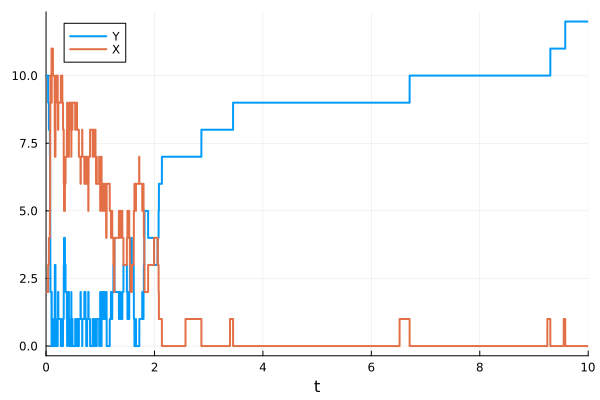

In [41]:
import Random
Random.seed!(123)
sol = solve(jprob, SSAStepper(), callback=cb)
plot(sol; lw=2)

The order which parameters and species appear in the model can be accessed by:

In [42]:
specie_names = species(prnbng.rn)
parameter_names = parameters(prnbng.rn)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 B
 A
 compartment

This can be used to, for example, set the value of parameter `B` to 3.0:

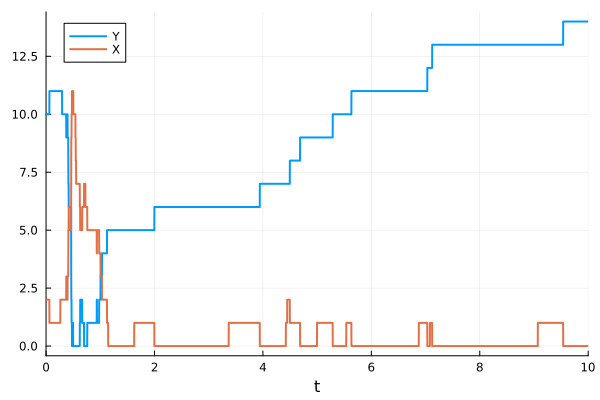

In [43]:
p = jprob.prob.p
p[findfirst(x -> x == "B", string.(parameter_names))] = 3.0
jprob = remake(jprob, p=p)
Random.seed!(123)
sol = solve(jprob, SSAStepper(), callback=cb)
plot(sol; lw=2)

## Comparing different simulators for a small model (4 reactions)

For most workflows, such as exploring model behavior by scanning parameter space, it is necessary to simulate the model many times (thousands to millions of simulations). This is because exact stochastic simulators such as, Gillespie methods, produce for a given parameter set one random trajectory per forward simulations. Therefore, to understand the model's behavior even for a single parameter set, numerous simulations are required. Consequently, selecting an efficient solver is crucial.

Several jump simulators are available for reaction networks via [JumpProcesses.jl](https://docs.sciml.ai/JumpProcesses/stable/). In particular for mass-action model, four different jump solvers are noteworthy to compare (further details available [here](https://docs.sciml.ai/JumpProcesses/stable/jump_types/#Jump-Aggregators-for-Exact-Simulation)):


* `Direct`: The Gillespie Direct method SSA
* `SortingDirect`: The Gillespie Direct method SSA with propensity sorting.
* `RSSA`: The Rejection SSA method.
* `RSSACR`: The Rejection SSA (RSSA) with Composition-Rejection method.

As a rough guideline, the `Direct` and `SortingDirect` methods usually perform best for smaller models. For larger models with more than 100 reactions, `RSSACR` tends to be the most efficient. Let us proceed to compare these solvers, by taking into consideration any potential initialization overhead by evaluating their performance for different simulation end points: 

In [44]:
# Function for comparing different methods
using BenchmarkTools
function compare_solver(prnbng, solver; endpoints = [10, 100, 1000])
    dprob = DiscreteProblem(prnbng.rn, prnbng.u₀, (0.0,0.0), prnbng.p)
    dprob = remake(dprob, u0 = Int64.(dprob.u0));
    jprob = JumpProblem(prnbng.rn, dprob, solver(), save_positions=(false,false))
    
    out = zeros(length(endpoints))
    for (i, tend) in pairs(endpoints)
        jprob_test = remake(jprob,tspan=(0.0, tend))
        btime = @benchmark solve($jprob_test, $(SSAStepper()))
        out[i] = median(btime.times) / 1e9 # Unit seconds
    end
    return out
end

res_Direct = compare_solver(prnbng, Direct)
res_SortingDirect = compare_solver(prnbng, SortingDirect)
res_RSSA = compare_solver(prnbng, RSSA)
res_RSSACR = compare_solver(prnbng, RSSACR)
nothing

And we can now plot the results for the different simulations end points:

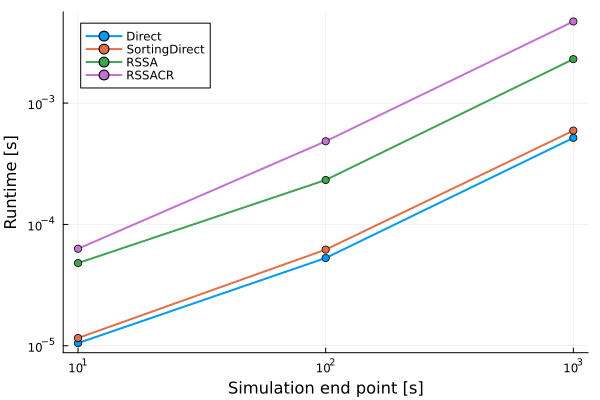

In [45]:
endpoints = [10, 100, 1000]
plot(endpoints, res_Direct; lw=2, xaxis=:log10, yaxis=:log10, label = "Direct", 
     ylabel = "Runtime [s]", xlabel = "Simulation end point [s]", 
     marker=:circle)
plot!(endpoints, res_SortingDirect; lw=2, label = "SortingDirect", marker=:circle)
plot!(endpoints, res_RSSA; lw=2, label = "RSSA", marker=:circle)
plot!(endpoints, res_RSSACR; lw=2, label = "RSSACR", marker=:circle)

In this case, the `Direct` method shows the best performance, especially for shorter simulation intervals where the sorting step in `SortingDirect` seem to introduce additional overhead. That `Direct` performs best is probably due to the model's simplicity (only 4 reactions). In larger systems ($\approx$ 20 reactions or more), the order of reactions in the model can influence the runtime. Hence, methods less sensitive to reaction order, like `SortingDirect`, are often a better choice.

## Comparing different simulators for a large model (288 reactions)

For evaluating different simulators on a bigger model, we will examine a multi-site phosphorylation model with 3 phosphorylation sites. The model has 288 reactions. To begin, we import the model using SBMLImporter, setting `mass_action=true` to inform the importer that the model follows mass-action kinetics: 

In [46]:
path_SBML = joinpath(@__DIR__, "Assets", "multisite3.xml")
prnbng, cb = load_SBML(path_SBML, mass_action=true)
nothing

And now we can compare the `Direct`, `SortingDirect`, `RSSA` and `RSSACR` methods:

In [47]:
res_Direct = compare_solver(prnbng, Direct)
res_SortingDirect = compare_solver(prnbng, SortingDirect)
res_RSSA = compare_solver(prnbng, RSSA)
res_RSSACR = compare_solver(prnbng, RSSACR)
nothing

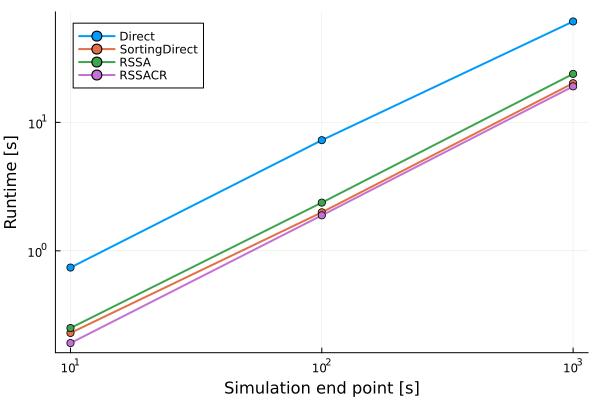

In [48]:
endpoints = [10, 100, 1000]
plot(endpoints, res_Direct; lw=2, xaxis=:log10, yaxis=:log10, label = "Direct", 
     ylabel = "Runtime [s]", xlabel = "Simulation end point [s]", 
     marker=:circle)
plot!(endpoints, res_SortingDirect; lw=2, label = "SortingDirect", marker=:circle)
plot!(endpoints, res_RSSA; lw=2, label = "RSSA", marker=:circle)
plot!(endpoints, res_RSSACR; lw=2, label = "RSSACR", marker=:circle)

For this larger model `RSSACR` performs best, which often holds for larger models. Moreover, `RSSACR` is quite insensitivity to the order of model reactions, especially when compared to `RSSA`, which makes `RSSACR` a good choice for workflows like model exploration.

## Next Steps

Since SBMLImporter.jl import models into a Catalyst `ReactionSystem`, thus anything that can be done with a `ReactionSystem` can be done with an imported model. For further exploration we strongly recommend the Catalyst [documentation](https://docs.sciml.ai/Catalyst/stable/).